In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.models import Model

# 1. Define custom constraint: force weights in [-1, 1]
class ClipConstraint(Constraint):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, w):
        return tf.clip_by_value(w, self.min_val, self.max_val)

# 2. Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 1024.0
x_test = x_test / 1024.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 3. Model: Small MLP with constraint using Functional API
constraint = ClipConstraint(-0.1, 0.1)
inputs = Input(shape=(784,))
x = Dense(16, activation='relu', kernel_constraint=constraint, bias_constraint=constraint)(inputs)
outputs = Dense(10, activation='sigmoid', kernel_constraint=constraint, bias_constraint=constraint)(x)
model = Model(inputs=inputs, outputs=outputs)

# 4. Compile and train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# 5. Evaluate
loss, acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# 6. Export weights and biases
W1, b1 = model.layers[1].get_weights()
W2, b2 = model.layers[2].get_weights()

# 7. Round to 4 decimal places and save
W1 = np.round(W1, 6)
b1 = np.round(b1, 6)
W2 = np.round(W2, 6)
b2 = np.round(b2, 6)

# 8. Save to .npy or print
np.savez('trained_weights_mnist.npz', W1=W1, b1=b1, W2=W2, b2=b2)

print("\nSample weights:")
print("W1 shape:", W1.shape)
print("W1[0][:5]:", W1[0][:5])


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5252 - loss: 1.9219 - val_accuracy: 0.7262 - val_loss: 1.6680
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6910 - loss: 1.6910 - val_accuracy: 0.7405 - val_loss: 1.6593
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7037 - loss: 1.6844 - val_accuracy: 0.7227 - val_loss: 1.6563
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6969 - loss: 1.6809 - val_accuracy: 0.7318 - val_loss: 1.6557
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7045 - loss: 1.6797 - val_accuracy: 0.7260 - val_loss: 1.6552
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6921 - loss: 1.7078

Test Accuracy: 71.18%

Sample weights:
W1 shape: (784, 16)
W1[0][:5]: [ 0.071421  0.0221    0.057993 -0.069415 -0.038104]


In [ ]:
model.save('best_model.h5')    # or .keras


In [ ]:
# Writing the weights in the .coe file
W1_list = W1.flatten().tolist()

output = []

for i, val in enumerate(W1_list):
    # Convert float to fixed-point binary (Q5.10)
    fixed = int(round(val * 1024))
    if fixed < 0:
        fixed = (1 << 16) + fixed
    bin_str = format(fixed & 0xFFFF, '016b')
    output.append(bin_str)

    # After every 16 elements, add 48 zeros
    if (i + 1) % 16 == 0:
        for _ in range(48):
            output.append('0000000000000000')

for i in range(15360):
  output.append('0000000000000000')


W2_list = W2.flatten().tolist()
for i, val in enumerate(W2_list):
    # Convert float to fixed-point binary (Q5.10)
    fixed = int(round(val * 1024))
    if fixed < 0:
        fixed = (1 << 16) + fixed
    bin_str = format(fixed & 0xFFFF, '016b')
    output.append(bin_str)

    # After every 10 elements, add 48 zeros
    if (i + 1) % 10 == 0:
        for _ in range(54):
            output.append('0000000000000000')

In [ ]:
# Writing biases into the file

b1_list = b1.flatten().tolist()

b_output = []

for i, val in enumerate(b1_list):
    # Convert float to fixed-point binary (Q5.10)
    fixed = int(round(val * 1024))
    if fixed < 0:
        fixed = (1 << 16) + fixed
    bin_str = format(fixed & 0xFFFF, '016b')
    b_output.append(bin_str)

    # After every 16 elements, add 48 zeros
    if (i + 1) % 16 == 0:
        for _ in range(48):
            b_output.append('0000000000000000')

b2_list = b2.flatten().tolist()


for i, val in enumerate(b2_list):
    # Convert float to fixed-point binary (Q5.10)
    fixed = int(round(val * 1024))
    if fixed < 0:
        fixed = (1 << 16) + fixed
    bin_str = format(fixed & 0xFFFF, '016b')
    b_output.append(bin_str)

    # After every 16 elements, add 48 zeros
    if (i + 1) % 10 == 0:
        for _ in range(54):
            b_output.append('0000000000000000')

In [ ]:
weights_file = "weights.coe"
bias_file = "bias.coe"
with open(weights_file, "w") as f:
    for line in output:
        f.write(line + ", \n")
with open(bias_file, "w") as f:
    for line in b_output:
        f.write(line + ", \n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[[0.45125875 0.7082124  0.48178792 0.49328026 0.3902329  0.38034257
  0.36621213 0.43125224 0.57710266 0.4502414 ]]
Predicted = 1 , Actual = 1


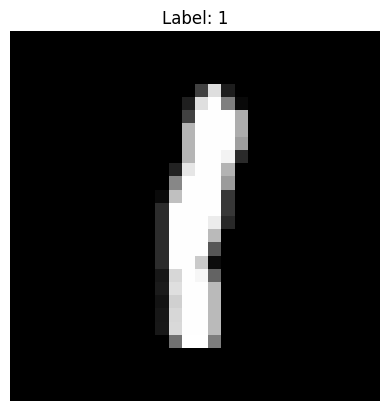

In [ ]:
# GENERATING INPUT DATA
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
j = 39
sample = x_test[j].reshape(1, -1)
pred = model.predict(sample)
actual = y_test[j]

# pred is of shape (1, 10), so extract the probabilities
p = pred[0]  # shape (10,)

# Find the index of the max probability (i.e., predicted class)
predicted = np.argmax(p)

print(pred)

print(f"Predicted = {predicted} , Actual = {actual}")

sample_list = sample.flatten().tolist()

sample_fp = []

for i, val in enumerate(sample_list):
    # Convert float to fixed-point binary (Q5.10)
    fixed = int(round(val * 1024))
    if fixed < 0:
        fixed = (1 << 16) + fixed
    bin_str = format(fixed & 0xFFFF, '016b')
    sample_fp.append(bin_str)

input_file = "input.txt"
i =0;

with open(input_file, "w") as f:
    for line in sample_fp:
        f.write(f"inputs[{i}] =16'b{line};\n")
        i = i+1

# Display the image
img = sample.reshape(28, 28)
plt.imshow(img, cmap='gray')  # grayscale
plt.title(f"Label: {y_test[j]}")
plt.axis('off')
plt.show()


In [ ]:
# Debugging for checking invididual layer and neuron computation

W1_T = np.transpose(W1)
W1_T.shape
b = b1[15]

def str_to_binary(s):
  if s[0]=='0':
    temp =0
    for i in range(1,16):
      temp += int(s[i])*(2**(5-i))
      # print(temp)
  else :
    temp = -(2**(5))
    for i in range(1,16):
      temp += int(s[i])*(2**(5-i))
      # print(temp)
  return temp

list = []
for i in range(16):
  b = b1[i]
  b += np.dot(np.array(x_test[123]),W1_T[i])
  list.append(b)
# print(list)
a = np.array(list)
W2_T = np.transpose(W2)
l2 = []
for i in range(10):
  qr = np.dot(a, W2_T[i])
  l2.append(qr)
e = np.array(l2) + b2
print(e)

# a = np.dot(a,W2_T)
# a = a + b_2
# for i in range(784):
#   vr = 64*i + 15
#   temp = str_to_binary(output[vr])
#   # print(f"{i} Output-: {temp} Weight -:{W1_T[15][i]} ")
#   b += np.dot(np.array(x_test[123][i]),W1_T[15][i])
#   print(f"{i} -: X = {x_test[123][i]} W = {W1_T[15][i]}  W_f = {temp}  Res=", b )
# len(x_test[123])
# print(b)


[-0.33309385 -0.53045501  0.5527473  -0.46918472  0.24974562 -0.64788244
  0.92292596 -0.4214909  -0.8881383   0.16689049]


In [ ]:
# 9. Get output of first hidden layer (16 values) for a test sample
sample_index = 123
sample_input = x_test[sample_index].reshape(1, -1)

# Create model that outputs from the first hidden layer
hidden_layer_model = Model(inputs=model.input, outputs=model.layers[1].output)
hidden_output = hidden_layer_model.predict(sample_input)

print("\nOutput of first hidden layer (16-dimensional):")
print(np.round(hidden_output[0], 4))

# Also show prediction
predicted = model.predict(sample_input)
print("\nPredicted class:", np.argmax(predicted))
print("Actual class:", y_test[sample_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Output of first hidden layer (16-dimensional):
[0.0738 0.0297 0.114  0.0388 0.1198 0.     0.086  0.     0.     0.1639
 0.     0.1159 0.034  0.     0.1324 0.0339]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

Predicted class: 6
Actual class: 6


In [ ]:
with open('weights.coe', 'r') as file:
    i = 0       # Line number tracker
    p = 0       # 16th-line tracker
    # j = 15

    for line in file:
        if i != 63:
          i += 1
        else:
          i =0

        if i == 16:
            first_16 = line[:16]
            print(f"{p}: {str_to_binary(first_16)} {W1_T[15][p]}")
            p += 1
            # j += 64

            if p == 784:
                break

0: -0.0380859375 -0.037776000797748566
1: -0.0869140625 -0.08656500279903412
2: -0.08203125 -0.08205299824476242
3: 0.0478515625 0.04792200028896332
4: 0.0009765625 0.000826000003144145
5: 0.0087890625 0.008457000367343426
6: -0.01953125 -0.019115999341011047
7: 0.0087890625 0.008864999748766422
8: -0.021484375 -0.021153999492526054
9: 0.0322265625 0.032221999019384384
10: -0.025390625 -0.02552800066769123
11: -0.0263671875 -0.026777999475598335
12: -0.048828125 -0.048760998994112015
13: -0.05078125 -0.05123699828982353
14: 0.03515625 0.03476300090551376
15: 0.099609375 0.10000000149011612
16: 0.0556640625 0.05602400004863739
17: -0.0712890625 -0.0712990015745163
18: 0.05078125 0.0505560003221035
19: 0.017578125 0.01793700084090233
20: 0.04296875 0.04275999963283539
21: -0.068359375 -0.06845200061798096
22: -0.0830078125 -0.08285299688577652
23: 0.0087890625 0.008705999702215195
24: 0.0029296875 0.002517000073567033
25: 0.0791015625 0.07956799864768982
26: 0.0234375 0.02308299951255321